In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
readers = pd.read_csv('readers.csv')
readers.head()

,reader_id,birth_day,age
0,366670,1974-10-14 00:00:00,46.079452
1,235264,1978-06-01 00:00:00,42.446575
2,133225,1976-01-06 00:00:00,44.849315
3,556716,1989-01-28 00:00:00,31.778082
4,52086,1955-08-14 00:00:00,65.260274


In [18]:
catalog = pd.read_csv('catalog.csv')
catalog.shape

(1370458, 10)

In [59]:
book_copy = pd.read_csv('samples.csv')
book_copy.head()

,book_id,doc_id,inventory_id,barcode,classification_id,singles_id
0,12488544,1,09:0000120386,980007854120,84(2Рос=Рус)6,314.0
1,12488546,1,09:0000152427,980010247056,84(2Рос=Рус)6,320.0
2,12488542,1,09:0000240622,980000737154,84(2Рос=Рус)6,306.0
3,13671389,1,09:0000278133,980005475303,84(2Рос=Рус)6,308.0
4,7625486,1,05:0000257728,580001931461,84(2Рос=Рус)6,293.0


In [3]:
booktake = pd.read_csv('issues.csv')
booktake.head()

,issue_id,reader_id,inventory_id,barcode,start_date,end_date,condition_id
0,1,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545
1,2,179,03:0000005761,381000196420,2018-04-13 15:00:00,2018-04-16 15:00:00,6548
2,3,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545
3,4,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545
4,5,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6548


In [5]:
booktake_copy = booktake.copy()

In [6]:
def to_datetime(x):
    try:
        return pd.to_datetime(str(x).strip(), format='%Y-%m-%d %H:%M:%S')
    except:
        return pd.to_datetime('2020-06-01 00:00:00', format='%Y-%m-%d %H:%M:%S')
#         try:
#             return pd.to_datetime(str(x).strip(), format='%Y-%m-%d')
#         except:
#             return #pd.to_datetime('2005-06-23 00:00:00', format='%Y-%m-%d')

In [7]:
booktake['start_date'] = booktake['start_date'].parallel_apply(lambda x: to_datetime(x))
booktake['end_date'] = booktake['end_date'].parallel_apply(lambda x: to_datetime(x))

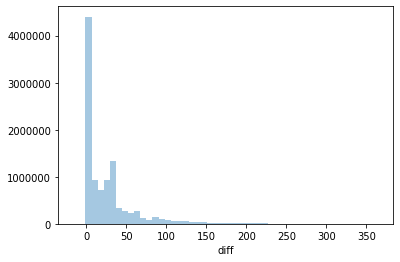

In [14]:
booktake['diff'] = booktake['end_date'] - booktake['start_date']
booktake['diff'] = booktake['diff'].astype(int) / 10**9 / 60 / 60 / 24

sns.distplot(booktake[booktake['diff'] < 365]['diff'], kde=False)

In [19]:
booktake.head()

,issue_id,reader_id,inventory_id,barcode,start_date,end_date,condition_id,diff
0,1,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,0.0
1,2,179,03:0000005761,381000196420,2018-04-13 15:00:00,2018-04-16 15:00:00,6548,3.0
2,3,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,0.0
3,4,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,0.0
4,5,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6548,0.0


In [42]:
booktake['reader_id'].value_counts().reset_index().rename(
    columns={'index': 'reader_id',
             'reader_id': 'book_count'})

,reader_id,book_count
0,231464,5285
1,341602,4936
2,332622,3653
3,351535,3383
4,332957,3284
...,...,...
450567,561566,1
450568,345193,1
450569,279625,1
450570,556809,1


In [44]:
readers = readers.merge(booktake['reader_id'].value_counts().reset_index().rename(
    columns={'index': 'reader_id',
             'reader_id': 'book_count'}),
              on='reader_id', how='left')
readers

,reader_id,birth_day,age,book_count
0,366670,1974-10-14 00:00:00,46.079452,5.0
1,235264,1978-06-01 00:00:00,42.446575,NaN
2,133225,1976-01-06 00:00:00,44.849315,NaN
3,556716,1989-01-28 00:00:00,31.778082,NaN
4,52086,1955-08-14 00:00:00,65.260274,NaN
...,...,...,...,...
562128,554754,1981-03-08 00:00:00,39.676712,NaN
562129,405813,2009-07-07 00:00:00,11.326027,6.0
562130,534901,2005-07-28 00:00:00,15.271233,4.0
562131,50142,2011-11-12 00:00:00,8.975342,51.0


In [48]:
readers.fillna(0, inplace=True)

In [52]:
readers.sort_values('book_count', ascending=False).head(50)

,reader_id,birth_day,age,book_count
67712,231464,1978-02-06 00:00:00,42.761644,5285.0
378055,341602,1989-03-14 00:00:00,31.654795,4936.0
519268,332622,1956-07-03 00:00:00,64.372603,3653.0
383543,351535,1987-03-13 00:00:00,33.660274,3383.0
519329,332957,1968-03-01 00:00:00,52.704110,3284.0
519779,335999,1951-01-12 00:00:00,69.849315,2959.0
435371,504511,1984-12-24 00:00:00,35.876712,2614.0
328592,333903,1953-09-20 00:00:00,67.158904,2571.0
201199,416159,1991-06-22 00:00:00,29.380822,2561.0
519244,332403,1946-08-03 00:00:00,74.295890,2560.0


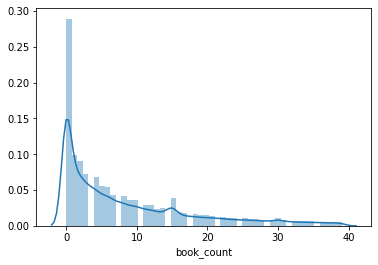

In [68]:
sns.distplot(readers[readers['book_count'] < 40]['book_count'])

In [62]:
catalog.head()

,doc_id,author,title,city,publisher,year,series,tags,article,age_rating
0,1,Устинова Татьяна Витальевна,Призрак Канта,Москва,Эксмо,2018,Татьяна Устинова. Первая среди лучших,Художественная литература ; Российский детектив,84(2Рос)6,16+
1,2,NaN,Наука и жизнь,Москва,АНО Редакция журнала «Наука и жизнь»,1938-,NaN,Наука. Науковедение,72,12+
2,3,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+
3,4,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+
4,5,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+


In [63]:
t = booktake[booktake.reader_id == 294840].merge(
    book_copy[['inventory_id', 'doc_id']], on='inventory_id', how='left').merge(
    catalog[['doc_id', 'age_rating']])
t

,issue_id,reader_id,inventory_id,barcode,start_date,end_date,condition_id,diff,doc_id,age_rating
0,3879703,294840,Б06:00010365,680013533056,2019-10-26 15:00:00,2019-10-26 15:00:00,6548,0.0,850147,0+
1,3998679,294840,Б06:00010365,680013533056,2019-11-01 15:00:00,2019-11-01 15:00:00,6548,0.0,850147,0+
2,6047799,294840,Б06:00010365,680013533056,2020-01-25 15:00:00,2020-01-25 15:00:00,6548,0.0,850147,0+
3,7128267,294840,Б06:00010365,680013533056,2020-02-22 15:00:00,2020-02-22 15:00:00,6548,0.0,850147,0+
4,3879704,294840,Б06:00015335,680013437439,2019-10-26 15:00:00,2019-10-26 15:00:00,6548,0.0,850160,0+
...,...,...,...,...,...,...,...,...,...,...
2010,8303959,294840,06:0000532319,680013553504,2020-03-27 15:00:00,2020-06-15 15:00:00,6544,80.0,1065349,NaN
2011,8303960,294840,06:0000532297,680013553498,2020-03-27 15:00:00,2020-06-15 15:00:00,6544,80.0,295851,NaN
2012,8303962,294840,06:0000532212,680013553474,2020-03-27 15:00:00,2020-06-15 15:00:00,6544,80.0,827840,NaN
2013,8303963,294840,06:0000532168,680013553467,2020-03-27 15:00:00,2020-06-15 15:00:00,6544,80.0,134437,NaN


In [64]:
t['age_rating'].value_counts()

6+     308
0+     290
12+     16
16+      1
Name: age_rating, dtype: int64

# Фичи читателей

In [73]:
readers = pd.read_csv('readers.csv')
readers.head()

,reader_id,birth_day,age
0,366670,1974-10-14 00:00:00,46.079452
1,235264,1978-06-01 00:00:00,42.446575
2,133225,1976-01-06 00:00:00,44.849315
3,556716,1989-01-28 00:00:00,31.778082
4,52086,1955-08-14 00:00:00,65.260274


In [74]:
# Кол-во прочитанных книг

readers = readers.merge(booktake['reader_id'].value_counts().reset_index().rename(
    columns={'index': 'reader_id',
             'reader_id': 'book_count'}),
              on='reader_id', how='left').fillna(0)
readers

,reader_id,birth_day,age,book_count
0,366670,1974-10-14 00:00:00,46.079452,5.0
1,235264,1978-06-01 00:00:00,42.446575,0.0
2,133225,1976-01-06 00:00:00,44.849315,0.0
3,556716,1989-01-28 00:00:00,31.778082,0.0
4,52086,1955-08-14 00:00:00,65.260274,0.0
...,...,...,...,...
562128,554754,1981-03-08 00:00:00,39.676712,0.0
562129,405813,2009-07-07 00:00:00,11.326027,6.0
562130,534901,2005-07-28 00:00:00,15.271233,4.0
562131,50142,2011-11-12 00:00:00,8.975342,51.0


# Фичи книг

In [109]:
booktake = booktake.drop_duplicates(['reader_id', 'doc_id', 'start_date', 'inventory_id']).reset_index(drop=True)

In [84]:
booktake = booktake.merge(book_copy[['inventory_id', 'doc_id']], on='inventory_id', how='left').merge(
               catalog[['doc_id', 'author', 'title', 'year', 'series', 'tags', 'age_rating']], 
                on='doc_id', how='left')
booktake.head()

,issue_id,reader_id,inventory_id,barcode,start_date,end_date,condition_id,diff,doc_id,author,title,year,series,tags,age_rating
0,1,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,0.0,5190,Семенова Мария Васильевна,Год Людоеда,2000,NaN,Художественная литература,NaN
1,2,179,03:0000005761,381000196420,2018-04-13 15:00:00,2018-04-16 15:00:00,6548,3.0,5185,NaN,Сказки о солдате,1999,Библиотека русской сказки,Художественная литература ; Фольклор России,NaN
2,3,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,0.0,5190,Семенова Мария Васильевна,Год Людоеда,2000,NaN,Художественная литература,NaN
3,4,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,0.0,5190,Семенова Мария Васильевна,Год Людоеда,2000,NaN,Художественная литература,NaN
4,5,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6548,0.0,5190,Семенова Мария Васильевна,Год Людоеда,2000,NaN,Художественная литература,NaN


In [94]:
booktake.shape

(10421656, 15)

In [96]:
booktake = booktake[~booktake['doc_id'].isna()]
booktake.shape

(10418067, 15)

In [110]:
booktake[['reader_id', 'doc_id']]

,reader_id,doc_id
0,179,5190
1,179,5185
2,163,5190
3,232,5456
4,232,5324
...,...,...
9027767,566212,336559
9027768,435542,240179
9027769,272505,600488
9027770,566211,707068


In [111]:
booktake[booktake.reader_id == 179].head(20)

,issue_id,reader_id,inventory_id,barcode,start_date,end_date,condition_id,diff,doc_id,author,title,year,series,tags,age_rating
0,1,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,0.0,5190,Семенова Мария Васильевна,Год Людоеда,2000,NaN,Художественная литература,NaN
1,2,179,03:0000005761,381000196420,2018-04-13 15:00:00,2018-04-16 15:00:00,6548,3.0,5185,NaN,Сказки о солдате,1999,Библиотека русской сказки,Художественная литература ; Фольклор России,NaN


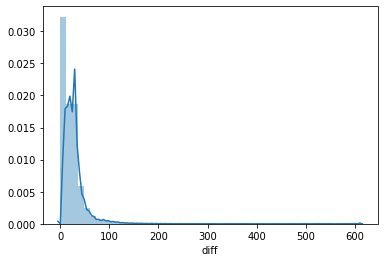

In [116]:
sns.distplot(booktake.groupby('doc_id')['diff'].mean())

In [121]:
t = booktake.groupby('doc_id')['diff'].agg(['mean', 'count']).reset_index()
t

,doc_id,mean,count
0,1.0,27.275624,1883
1,3.0,2.713333,1350
2,4.0,3.447123,1286
3,5.0,4.337034,1261
4,6.0,3.000000,17
...,...,...,...
624903,1783587.0,9.000000,1
624904,1783590.0,9.000000,1
624905,1783591.0,19.500000,2
624906,1783614.0,30.000000,1


In [132]:
catalog = catalog.merge(t, on='doc_id', how='left')
catalog['mean'] = catalog['mean'].fillna(0)
catalog['count'] = catalog['count'].fillna(0)
catalog.head()

,doc_id,author,title,city,publisher,year,series,tags,article,age_rating,mean,count
0,1,Устинова Татьяна Витальевна,Призрак Канта,Москва,Эксмо,2018,Татьяна Устинова. Первая среди лучших,Художественная литература ; Российский детектив,84(2Рос)6,16+,27.275624,1883.0
1,2,NaN,Наука и жизнь,Москва,АНО Редакция журнала «Наука и жизнь»,1938-,NaN,Наука. Науковедение,72,12+,0.000000,0.0
2,3,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,2.713333,1350.0
3,4,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,3.447123,1286.0
4,5,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,4.337034,1261.0


In [162]:
catalog['rating'] = np.log(catalog['count'].values + 1)
catalog.head()

,doc_id,author,title,city,publisher,year,series,tags,article,age_rating,mean,count,rating
0,1,Устинова Татьяна Витальевна,Призрак Канта,Москва,Эксмо,2018,Татьяна Устинова. Первая среди лучших,Художественная литература ; Российский детектив,84(2Рос)6,16+,27.275624,1883.0,7.541152
1,2,NaN,Наука и жизнь,Москва,АНО Редакция журнала «Наука и жизнь»,1938-,NaN,Наука. Науковедение,72,12+,0.000000,0.0,0.000000
2,3,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,2.713333,1350.0,7.208600
3,4,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,3.447123,1286.0,7.160069
4,5,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,4.337034,1261.0,7.140453


In [171]:
ratings = booktake[['reader_id', 'doc_id']].merge(catalog[['doc_id', 'rating']], on='doc_id', how='left').fillna(0).drop_duplicates()
ratings

,reader_id,doc_id,rating
0,179,5190.0,1.386294
1,179,5185.0,1.609438
2,163,5190.0,1.386294
3,232,5456.0,5.105945
4,232,5324.0,5.645447
...,...,...,...
9027767,566212,336559.0,4.997212
9027768,435542,240179.0,3.091042
9027769,272505,600488.0,3.135494
9027770,566211,707068.0,1.098612


In [172]:
catalog

,doc_id,author,title,city,publisher,year,series,tags,article,age_rating,mean,count,rating
0,1,Устинова Татьяна Витальевна,Призрак Канта,Москва,Эксмо,2018,Татьяна Устинова. Первая среди лучших,Художественная литература ; Российский детектив,84(2Рос)6,16+,27.275624,1883.0,7.541152
1,2,NaN,Наука и жизнь,Москва,АНО Редакция журнала «Наука и жизнь»,1938-,NaN,Наука. Науковедение,72,12+,0.000000,0.0,0.000000
2,3,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,2.713333,1350.0,7.208600
3,4,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,3.447123,1286.0,7.160069
4,5,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,4.337034,1261.0,7.140453
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370453,1783623,NaN,Золотой век русской поэзии [Текст],Москва,Олма Медиа Групп,2012,Классика в иллюстрациях,Художественная литература,84,NaN,0.000000,0.0,0.000000
1370454,1783624,NaN,Антология русского лиризма. XX век,Москва,Студия,2004-,NaN,Художественная литература ; Российская поэзия,84(2Рос=Рус)6,NaN,0.000000,0.0,0.000000
1370455,1783625,Кэрролл Льюис,Приключения Алисы,Москва,Эксмо,2014,NaN,Художественная литература ; Литература для дет...,84(4Вел),12+,0.000000,0.0,0.000000
1370456,1783626,Барб-Галль Франсуаза,"Шедевры мировой живописи. Как отличать, смотре...",Москва,Эксмо,2018,NaN,Живопись ; Искусство. Искусствоведение ; Истор...,85.14,12+,0.000000,0.0,0.000000


In [173]:
ratings.to_csv('ratings.csv', index=False)

In [174]:
catalog.to_csv('books.csv', index=False)

In [191]:
catalog

,doc_id,author,title,city,publisher,year,series,tags,article,age_rating,mean,count,rating
0,1,Устинова Татьяна Витальевна,Призрак Канта,Москва,Эксмо,2018,Татьяна Устинова. Первая среди лучших,Художественная литература ; Российский детектив,84(2Рос)6,16+,27.275624,1883.0,7.541152
1,2,NaN,Наука и жизнь,Москва,АНО Редакция журнала «Наука и жизнь»,1938-,NaN,Наука. Науковедение,72,12+,0.000000,0.0,0.000000
2,3,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,2.713333,1350.0,7.208600
3,4,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,3.447123,1286.0,7.160069
4,5,NaN,Наука и жизнь,NaN,NaN,2018,NaN,Наука. Науковедение,72,12+,4.337034,1261.0,7.140453
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370453,1783623,NaN,Золотой век русской поэзии [Текст],Москва,Олма Медиа Групп,2012,Классика в иллюстрациях,Художественная литература,84,NaN,0.000000,0.0,0.000000
1370454,1783624,NaN,Антология русского лиризма. XX век,Москва,Студия,2004-,NaN,Художественная литература ; Российская поэзия,84(2Рос=Рус)6,NaN,0.000000,0.0,0.000000
1370455,1783625,Кэрролл Льюис,Приключения Алисы,Москва,Эксмо,2014,NaN,Художественная литература ; Литература для дет...,84(4Вел),12+,0.000000,0.0,0.000000
1370456,1783626,Барб-Галль Франсуаза,"Шедевры мировой живописи. Как отличать, смотре...",Москва,Эксмо,2018,NaN,Живопись ; Искусство. Искусствоведение ; Истор...,85.14,12+,0.000000,0.0,0.000000


In [203]:
tags = catalog['tags'].value_counts().reset_index()
tags

,index,tags
0,Художественная литература,489074
1,История России,59354
2,Литература для детей и юношества,22982
3,История и критика литературы России,22498
4,История в целом. Всемирная история,22099
...,...,...
9067,Издания универсального содержания ; История фи...,1
9068,Религия в целом. Религиоведение ; Экология,1
9069,Теория и история музыки ; Музыка. Музыковедени...,1
9070,Хореографический театр (балет) ; Художественна...,1


In [198]:
catalog['tags'].map(str).map(str.lower).str.contains('история').mean()

0.1273807734348663